# **[딥러닝을 이용한 자연어 처리 입문]**

+ 11 RNN을 이용한 텍스트 분류 

+ 7) 네이버 쇼핑 리뷰 감성 분류하기(Naver Shopping Review Sentiment Analysis)를 참고하였습니다. 

+ https://wikidocs.net/94600

In [7]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 29.6 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-08-15 12:47:47--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import io

## 데이터 불러오기

In [4]:
from google.colab import drive
drive.mount('/content/drive/MyDrive')

Mounted at /content/drive/MyDrive


In [9]:
data = pd.read_csv('/content/drive/MyDrive/MyDrive/Apple(shopping).csv')

In [10]:
data.head()

,Unnamed: 0,type,category,review,star
0,0,아이패드,별점,고장나서 옴 수리하기도 돈아까윰,1
1,1,아이패드,별점,그냥 모든게 허접해요,1
2,2,아이패드,별점,NaN,1
3,3,아이패드,별점,대응이 정말 안좋아요,1
4,4,아이패드,별점,액정 불량화소 있어서 말하니 센터가서 처리하라고하네 편하게 받고 싶은데 다시 가서 ...,1


## 데이터 전처리

In [11]:
data = data.dropna()
data = data.drop_duplicates()

In [12]:
data["label"] = np.select([data.star > 3], [1], default=0)
data[:5]

,Unnamed: 0,type,category,review,star,label
0,0,아이패드,별점,고장나서 옴 수리하기도 돈아까윰,1,0
1,1,아이패드,별점,그냥 모든게 허접해요,1,0
3,3,아이패드,별점,대응이 정말 안좋아요,1,0
4,4,아이패드,별점,액정 불량화소 있어서 말하니 센터가서 처리하라고하네 편하게 받고 싶은데 다시 가서 ...,1,0
5,5,아이패드,별점,일주일이 넘도록 환불처리가 되지 않아 빠른 답변 부탁드립니다,1,0


In [13]:
data['star'].nunique(), data["review"].nunique(), data["star"].nunique() # (5, 2342, 5)

(5, 2342, 5)

In [14]:
print(data.isnull().sum())

Unnamed: 0    0
type          0
category      0
review        0
star          0
label         0
dtype: int64


In [15]:
train_data, test_data = train_test_split(data, test_size = 0.3, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 1649
테스트용 리뷰의 개수 : 707


## 레이블 분포 확인

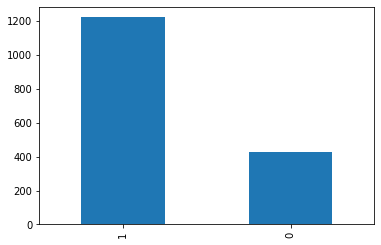

In [16]:
train_data["label"].value_counts().plot(kind = 'bar')

In [17]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0    426
1      1   1223


## 토큰화

In [18]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [19]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과',
             '도','를','으로','자','에','와','한','하다', '게',
             '고', '네', '는', '다', '들', '듯', '으로', '은',
             '을', '인', '임', '자', '좀', '지', '요']

In [20]:
train_data["tokenized"] = train_data["review"].apply(mecab.morphs)
train_data["tokenized"] = train_data["tokenized"].apply(lambda x : [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
test_data["tokenized"] = test_data["review"].apply(mecab.morphs)
test_data["tokenized"] = test_data["tokenized"].apply(lambda x : [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [23]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('하', 320), ('네요', 203), ('있', 166), ('는데', 158), ('안', 148), ('받', 136), ('했', 117), ('습니다', 109), ('좋', 107), ('제품', 106), ('되', 103), ('월', 103), ('어요', 94), ('거', 78), ('어', 77), ('았', 75), ('서', 72), ('주', 71), ('구매', 70), ('없', 69)]


In [24]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('하', 1378), ('좋', 770), ('있', 571), ('는데', 550), ('습니다', 541), ('네요', 529), ('했', 494), ('어요', 464), ('구매', 316), ('너무', 312), ('아요', 312), ('사용', 311), ('받', 310), ('로', 307), ('되', 302), ('았', 293), ('같', 282), ('쓰', 264), ('어', 260), ('합니다', 257)]


In [25]:
positive_len = train_data[train_data['label']==1]["tokenized"].map(lambda x : len(x))
np.mean(positive_len)

32.865903515944396

In [26]:
negative_len = train_data[train_data['label']==0]["tokenized"].map(lambda x : len(x))
np.mean(negative_len)

25.92488262910798

In [27]:
X_train = train_data["tokenized"].values
y_train = train_data["label"].values
X_test = test_data["tokenized"].values
y_test = test_data["label"].values

## 정수 인코딩

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [29]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수의 쌍을 key와 value로
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4934
등장 빈도가 1번 이하인 희귀 단어의 수: 2355
단어 집합에서 희귀 단어의 비율: 47.730036481556546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.596108433029529


In [30]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 2581


In [31]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [32]:
print(X_train[:3])

[[85, 2, 12, 8, 9, 69, 579, 78, 215, 5, 271, 54, 42, 54, 42, 49, 446, 1136, 6, 88, 49, 46, 199, 27, 19, 37, 1, 1, 16, 190, 187, 68, 56, 76, 1137, 9, 816, 1305, 4, 898, 36, 65, 2, 86, 49, 49, 12, 2, 1005, 239, 2, 51, 1902, 26, 647], [71, 38, 40, 204, 2, 1306, 1006, 40, 170, 38, 40, 204, 33, 77, 8, 701, 117, 17, 184, 3, 13, 413, 1531, 128, 16, 301, 96, 33, 204, 372, 117, 311, 3, 139, 145, 1306, 1006, 40, 140, 447, 176, 9, 1, 1, 1903, 1, 55, 22, 899, 212, 39, 121, 1, 240, 3, 32, 84, 88, 514, 263, 15, 1138, 817, 1139, 8, 163, 250, 1, 1, 1, 15, 282, 11, 542, 65, 2, 57, 82, 384, 543, 133, 1904, 38, 40, 900, 302, 6, 169, 2, 51, 58, 241, 75, 133, 303, 46, 87, 35, 80, 312, 15, 61, 105, 817, 1139, 8, 1307, 250, 117, 311, 3, 13, 283, 762, 1308, 43, 1, 514, 228, 901, 319, 65, 8, 6, 88, 514, 17, 320, 1007, 122, 1, 122, 128, 14, 6, 1905, 51, 177, 26, 4, 242, 212, 257, 763, 515, 258, 4, 466, 134, 47, 17, 1, 3, 13, 71, 38, 40, 1906, 22, 902, 94, 134, 47, 136, 1008, 1009, 432, 414, 37, 1309], [164, 190

In [33]:
print(X_test[:3])

[[963, 433, 1757, 750, 9, 73, 2, 212, 188, 94, 10, 58, 17, 3, 14, 9], [170, 2114, 61, 6, 170, 1, 16, 17, 43, 89, 64, 1716, 183, 1713, 1408, 1, 170, 380, 149, 1024, 1, 985, 38, 55, 4, 45, 542, 271, 1716, 38, 40, 21, 80, 53, 245, 1, 772, 19, 20, 313, 478, 184, 21, 572, 114, 50, 110, 1, 300, 55, 4, 29, 209, 169, 2, 51, 7, 586, 89, 30, 587, 174, 381, 138, 46, 168, 221, 167, 5, 273, 572, 228, 271, 572, 349, 273, 1, 1687, 186, 1, 15, 143, 590, 22, 95, 33, 273, 572, 16, 61, 6, 43, 207, 1, 1, 1, 122, 170, 38, 40, 2181, 15, 302, 41, 3, 58, 72, 245, 403, 46, 97, 8, 6, 122, 2344, 18, 89, 64, 222], [347, 1, 203, 186, 1, 27, 1, 39, 87, 7, 1058, 3, 1432, 93, 43, 23]]


## 패딩

리뷰의 최대 길이 : 581
리뷰의 평균 길이 : 31.072771376591874


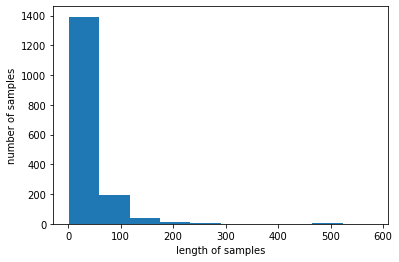

In [34]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train)) / len(X_train))
plt.hist([len(s) for s in X_train], bins = 10)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [55]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s) <= max_len):
            cnt = cnt+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s' %(max_len, (cnt / len(nested_list))* 100))

In [56]:
max_len = 200
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 200 이하인 샘플의 비율 : 100.0


In [57]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [58]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [59]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation = 'sigmoid'))

In [60]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [61]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
22/22 [==============================] - 9s 332ms/step - loss: 0.5671 - acc: 0.7210 - val_loss: 0.5151 - val_acc: 0.7576

Epoch 00001: val_acc improved from -inf to 0.75758, saving model to best_model.h5
Epoch 2/15
22/22 [==============================] - 7s 303ms/step - loss: 0.4509 - acc: 0.7908 - val_loss: 0.4863 - val_acc: 0.7909

Epoch 00002: val_acc improved from 0.75758 to 0.79091, saving model to best_model.h5
Epoch 3/15
22/22 [==============================] - 7s 308ms/step - loss: 0.3238 - acc: 0.8741 - val_loss: 0.4889 - val_acc: 0.8121

Epoch 00003: val_acc improved from 0.79091 to 0.81212, saving model to best_model.h5
Epoch 4/15
22/22 [==============================] - 7s 305ms/step - loss: 0.2623 - acc: 0.8992 - val_loss: 0.4981 - val_acc: 0.7879

Epoch 00004: val_acc did not improve from 0.81212
Epoch 5/15
22/22 [==============================] - 7s 308ms/step - loss: 0.2071 - acc: 0.9234 - val_loss: 0.5158 - val_acc: 0.7879

Epoch 00005: val_acc did not impr

In [62]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

23/23 [==============================] - 1s 43ms/step - loss: 0.3571 - acc: 0.8586

 테스트 정확도: 0.8586


## 리뷰 예측해보기

In [63]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [64]:
sentiment_predict("이 상품 진짜 좋아요... 저는 강추합니다. 대박")

93.10% 확률로 긍정 리뷰입니다.


In [65]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

76.31% 확률로 부정 리뷰입니다.


In [66]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

80.71% 확률로 긍정 리뷰입니다.


In [67]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

57.90% 확률로 부정 리뷰입니다.


In [69]:
sentiment_predict('아이패드 화면 불량인가요,안녕하세요이번에 아이패드랑 펜슬까지 구매완료해서아이폰 애플워치 에어팟ㅎㅎㅎ 사과농장 다꾸럈어요처음으로 태블릿을 샀는데 ㅋㅍ에서 사서 신나게 펜슬로 끄적이고있었는데 동영상처럼 오류가 뜨더라구요ㅠ아이패드불량아이패드에어불량아이패드멍현상에어화면눌림현상 보시면 이렇게 오류가 생기더라구요ㅠ 크게 힘을 누른것도 아닌데 펜슬로 쓰다보니 나비모양처럼 되던데 불량인가요찝찝해서 교환해서 새상품을 받았는데 새로받은걸 확인 차 눌러보니깐 새상품에서도 나타나더라구요 기존에 갖고있던 갤탭은 나비모양처럼 멍현상은 없던데 제가 뽑기실패를 한건지 예민한건지 모르겠어요ㅠ')

80.43% 확률로 부정 리뷰입니다.


In [70]:
sentiment_predict('주목적은 그림영상시청 주로 집에서 사용좋은 점  화면 움직임같은게 정말 스무스하고 느낌이 좋습니다 크아 정말 이걸로 뭐라도 해야할 것 같은 느낌  솔직히 스피커에서 제일 놀랐구요소리가 진짜 빵빵하고 좋아요 영상시청으로 최적인것 같아요')

99.81% 확률로 긍정 리뷰입니다.
